In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(rc={'figure.figsize':(10, 7)}, style='darkgrid')
sns.set_color_codes()

from scipy.stats import norm

import cv2

import os

import glob
import datetime
import itertools
import random

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
df = pd.read_csv("../input/data/Data_Entry_2017.csv")
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [4]:
labels = list(np.unique(list(itertools.chain(*df['Finding Labels'].map(lambda x: x.split('|'))))))
print(f"Labels: {labels}")
print(f"Unique labels: {len(labels)}")

Labels: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
Unique labels: 15


In [5]:
to_remove = {"Pleural_Thickening", "Fibrosis", "Edema", "Emphysema"}
labels = [x for x in labels if x not in to_remove]

print(f"Before removing: {df.shape[0]} images")
for i in range(len(df)):
    disease = df['Finding Labels'][i].split("|")
    for j in disease:
        if j in to_remove:
            df.drop(i, inplace=True)
            break
print(f"After removing: {df.shape[0]} images")
df.index = np.arange(0, df.shape[0]) # reset index

Before removing: 112120 images
After removing: 102692 images


In [6]:
labels = [x for x in labels if x != 'No Finding']
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Effusion',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pneumonia',
 'Pneumothorax']

In [7]:
all_img_paths = glob.glob('../input/data/images*/images/*.png')
img_path_dict = {os.path.basename(x): x for x in all_img_paths}
df['img_path'] = df['Image Index'].map(img_path_dict.get)

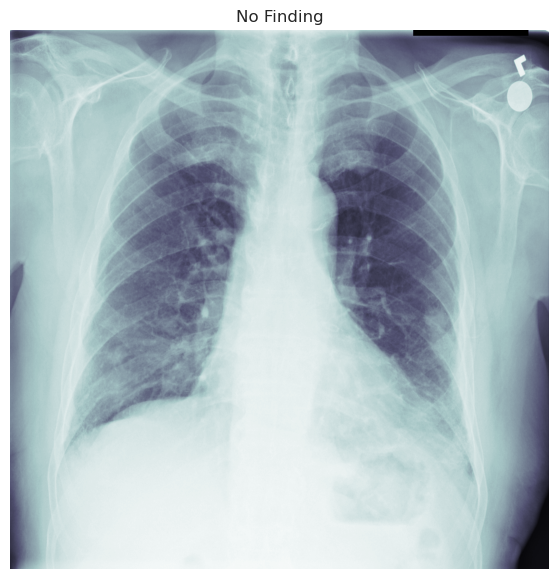

In [8]:
from PIL import Image

fig, ax = plt.subplots()
img = df.iloc[:, -1][2]
label = df.iloc[:, 1][2]

arr = Image.open(img) # load image
ax.imshow(arr, cmap="bone")
ax.set_title(label)
ax.axis(False);

In [9]:
import random
from PIL import Image
def get_random_images(k=16):
    random_img_sample = random.sample(range(df.shape[0]), k=k)
    
    # Plot
    plt.figure(figsize=(20, 20))
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
    
    for i, idx in enumerate(random_img_sample):
        plt.subplot(4, 4, i + 1)
        img = df.iloc[:, -1][idx]
        label = df.iloc[:, 1][idx]

        arr = Image.open(img) # load image
        plt.imshow(arr, cmap="bone")
        plt.title(label)
        plt.axis(False)
        
    plt.suptitle("Images from the dataset", fontsize=14)
plt.show()

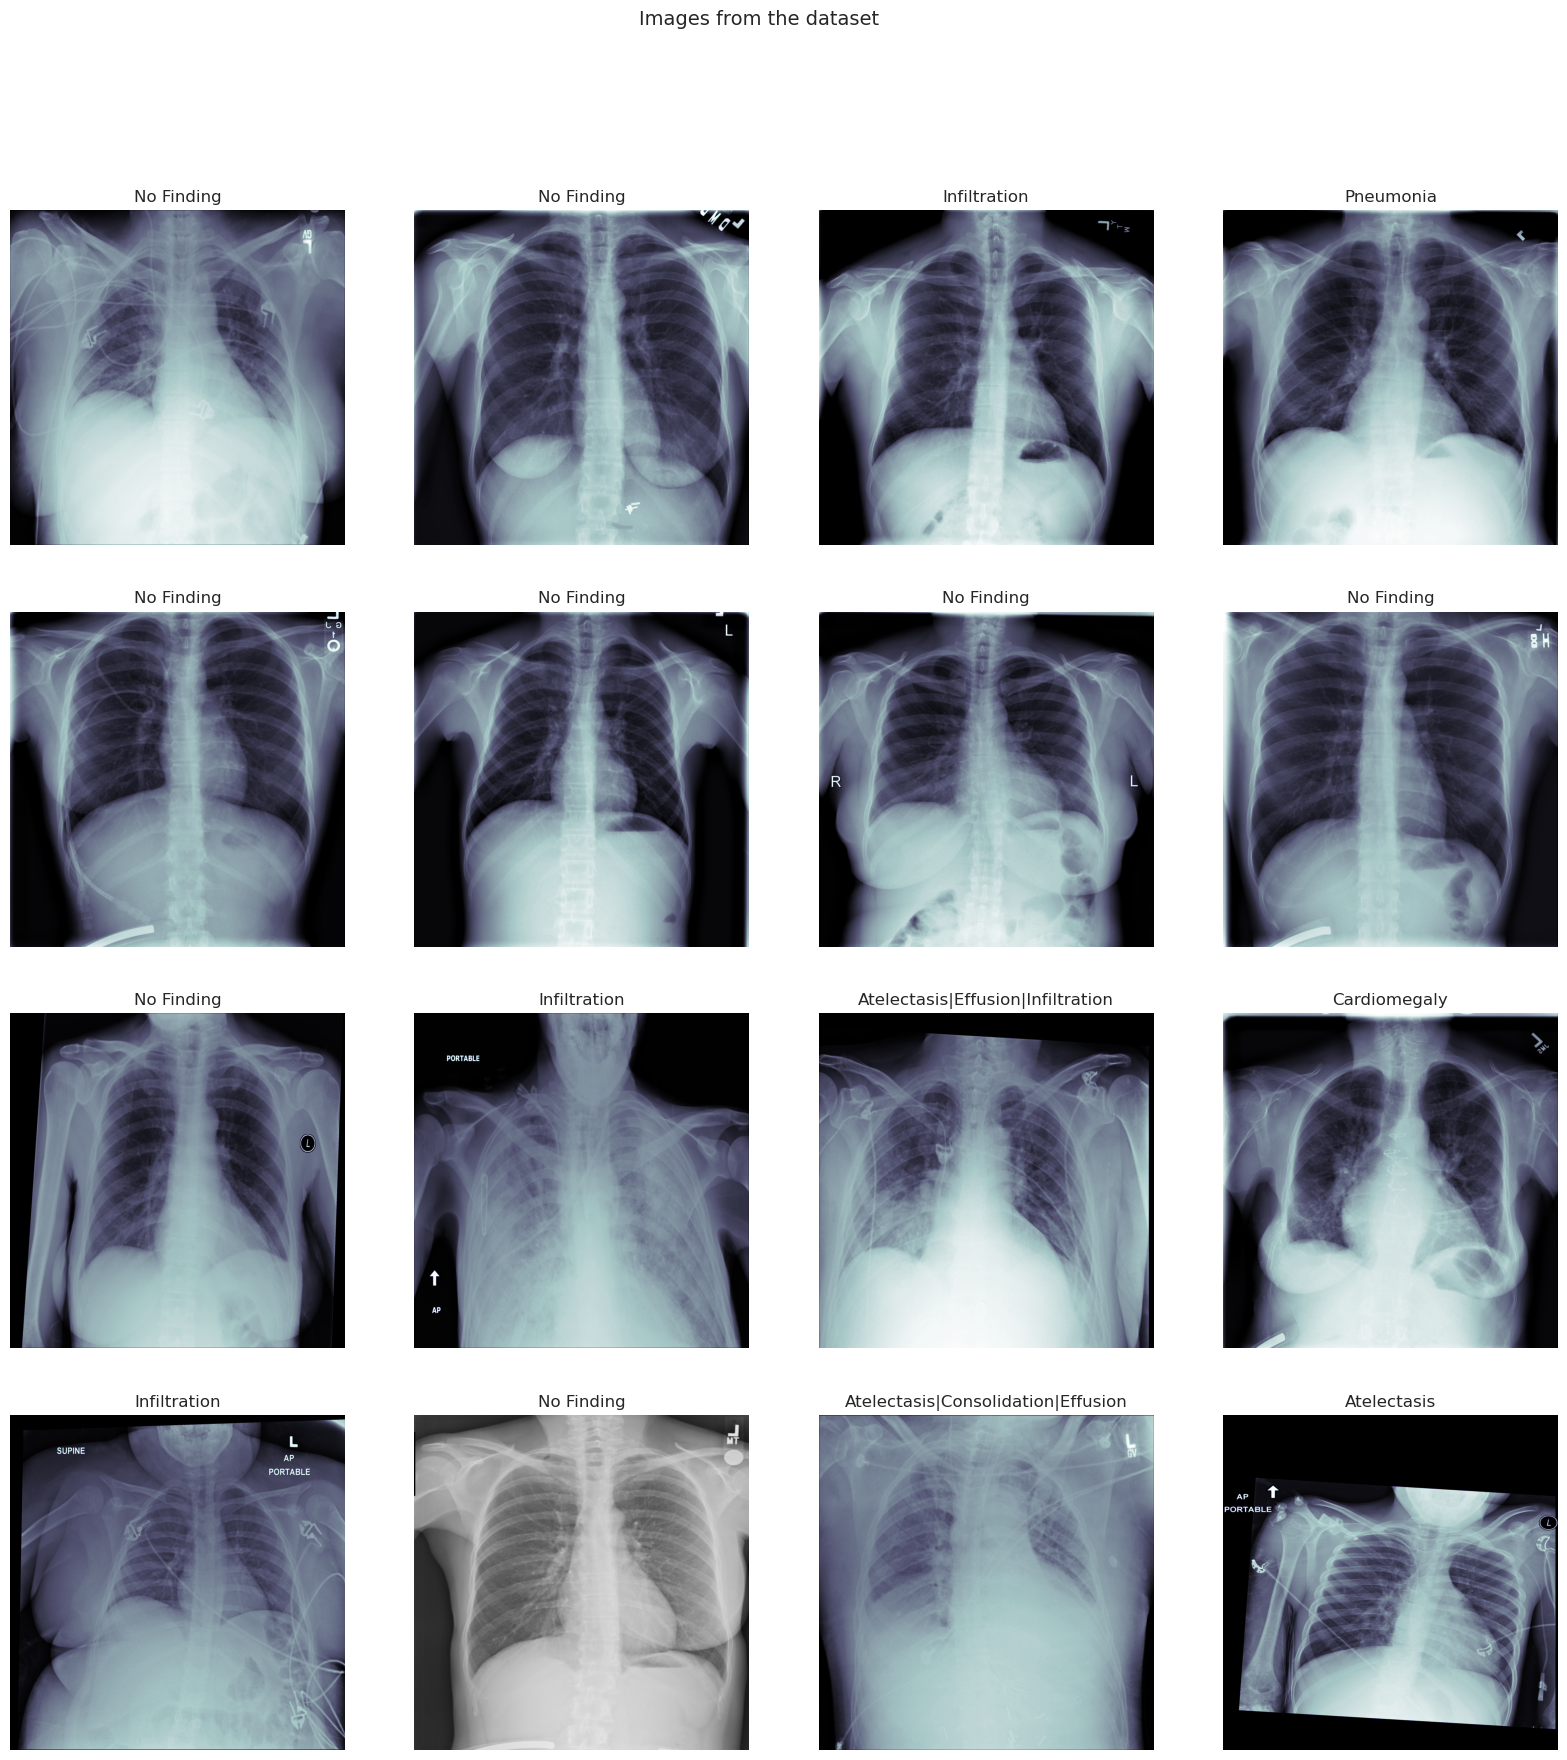

In [10]:
 get_random_images()

In [11]:
bbox = pd.read_csv("../input/data/BBox_List_2017.csv")
bbox

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
979,00029464_015.png,Atelectasis,198.940451,352.900747,615.537778,323.128889,NaN,NaN,NaN
980,00025769_001.png,Atelectasis,701.838229,572.491858,103.537778,63.715556,NaN,NaN,NaN
981,00016837_002.png,Atelectasis,140.913785,658.962969,271.928889,94.435556,NaN,NaN,NaN
982,00020124_003.png,Atelectasis,175.047118,580.456302,244.622222,103.537778,NaN,NaN,NaN


In [12]:
bbox['img_path'] = bbox['Image Index'].map(img_path_dict.get)
bbox.head()

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8,img_path
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN,../input/data/images_006/images/00013118_008.png
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN,../input/data/images_007/images/00014716_007.png
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN,../input/data/images_012/images/00029817_009.png
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN,../input/data/images_007/images/00014687_001.png
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN,../input/data/images_008/images/00017877_001.png


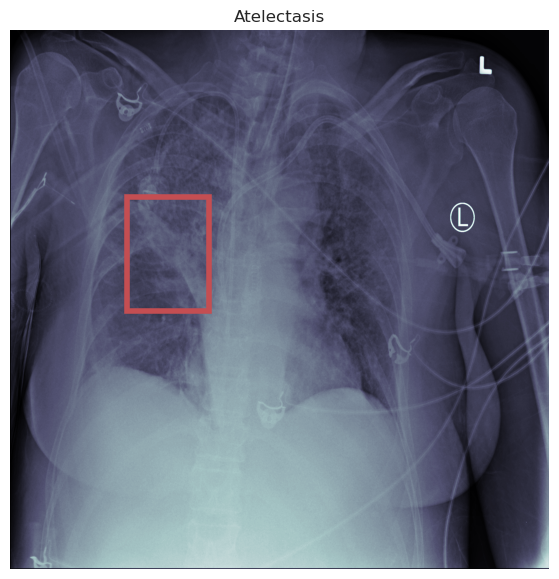

In [13]:
from PIL import Image
import matplotlib.patches as patches 

fig, ax = plt.subplots()

img = bbox.iloc[:, -1][2]
label = bbox.iloc[:, 1][2]

arr = Image.open(img)
ax.imshow(arr, cmap='bone')

x = bbox['Bbox [x'][2]
y = bbox['y'][2]
w = bbox['w'][2]
h = bbox['h]'][2]

rect = patches.Rectangle((x, y), w, h, linewidth=4, edgecolor='r', facecolor='none')

ax.add_patch(rect)

ax.set_title(label)
ax.axis(False);

In [14]:
df = df[['Finding Labels', 'img_path']]
df

,Finding Labels,img_path
0,Cardiomegaly,../input/data/images_001/images/00000001_000.png
1,Cardiomegaly|Effusion,../input/data/images_001/images/00000001_002.png
2,No Finding,../input/data/images_001/images/00000002_000.png
3,Hernia,../input/data/images_001/images/00000003_000.png
4,Hernia,../input/data/images_001/images/00000003_001.png
...,...,...
102687,Mass|Pneumonia,../input/data/images_012/images/00030801_001.png
102688,No Finding,../input/data/images_012/images/00030802_000.png
102689,No Finding,../input/data/images_012/images/00030803_000.png
102690,No Finding,../input/data/images_012/images/00030804_000.png


In [15]:
df['Finding Labels'].value_counts()

No Finding                                                  60361
Infiltration                                                 9547
Atelectasis                                                  4215
Effusion                                                     3955
Nodule                                                       2705
                                                            ...  
Cardiomegaly|Effusion|Infiltration|Pneumonia                    1
Cardiomegaly|Mass|Nodule                                        1
Effusion|Pneumothorax|Mass                                      1
Atelectasis|Hernia|Mass                                         1
Atelectasis|Hernia|Infiltration|Mass|Nodule|Pneumothorax        1
Name: Finding Labels, Length: 286, dtype: int64

In [16]:
for label in labels:
    df[label] = df['Finding Labels'].map(lambda exist: 1 if label in exist else 0)

In [17]:
df.shape

(102692, 12)

In [18]:
df['Finding Labels'] = df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x) > 0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label) > 1: # leave out empty labels
        df[c_label] = df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
        df.sample(3)

All Labels (10): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax']


In [19]:
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(df[c_label].sum())) for c_label in all_labels])

Clean Labels (9) [('Atelectasis', 10271), ('Cardiomegaly', 2459), ('Consolidation', 4106), ('Effusion', 11433), ('Infiltration', 17491), ('Mass', 4928), ('Nodule', 5564), ('Pneumonia', 1032), ('Pneumothorax', 4227)]


In [20]:
sample_weights = df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
df = df.sample(100000, weights=sample_weights)

In [21]:
df['Finding Labels'].value_counts()

                                                               57669
Infiltration                                                    9547
Atelectasis                                                     4215
Effusion                                                        3955
Nodule                                                          2705
                                                               ...  
Atelectasis|Hernia|Infiltration|Mass|Nodule|Pneumothorax           1
Atelectasis|Mass|Nodule|Pneumonia                                  1
Atelectasis|Mass|Nodule|Pneumothorax                               1
Atelectasis|Consolidation|Effusion|Mass|Nodule|Pneumothorax        1
Consolidation|Pneumonia|Mass                                       1
Name: Finding Labels, Length: 286, dtype: int64

In [ ]:
df['disease_vec'] = df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [ ]:
counts = df['Finding Labels'].value_counts()
mask = df['Finding Labels'].isin(counts[counts >= 200].index)
df = df[mask]

In [ ]:
threshold = 0.75
category_to_delete = ''

# Select rows with the specified category
category_rows = df[df['Finding Labels'] == category_to_delete]

# Calculate the number of rows to delete
num_rows_to_delete = int(len(category_rows) * threshold)

# Randomly select rows to delete
rows_to_delete = np.random.choice(category_rows.index, size=num_rows_to_delete, replace=False)

# Delete selected rows from the DataFrame
df = df.drop(rows_to_delete)

In [ ]:
train, test = train_test_split(df, train_size=0.8, random_state=42)
X_train, X_test = train_test_split(train, train_size=0.8, random_state=42)

In [ ]:
train_gen = ImageDataGenerator(rescale=1/255.)
test_gen = ImageDataGenerator(rescale=1/255.)
valid_gen = ImageDataGenerator(rescale=1/255.)

In [ ]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [ ]:
train.head()

In [ ]:
print("Training images:")
train_data = train_gen.flow_from_dataframe( X_train,
                                           x_col="img_path",
                                           y_col=labels,  
                                           target_size=(224, 224),
                                           classes=labels,
                                           color_mode="rgb",
                                           class_mode="raw",
                                           seed=42,
                                           batch_size=32)

print("Validation images:")
valid_data = valid_gen.flow_from_dataframe( X_test,
                                           x_col="img_path",
                                           y_col=labels, 
                                           target_size=(224, 224),
                                           classes=labels,
                                           color_mode="rgb",
                                           class_mode="raw",
                                           seed=42,
                                           batch_size=32)

print("Testing images:")
test_data = test_gen.flow_from_dataframe(test,
                                         x_col="img_path",
                                         y_col=labels,
                                         target_size=(224, 224),
                                         classes=labels,
                                         color_mode="rgb",
                                         class_mode="raw",
                                         shuffle=False,
                                         seed=42,
                                         batch_size=32)

In [ ]:
labels

In [ ]:
train_x, train_y = next(train_data)
print(f"Image dimensions: {train_x[1].shape}")
print(f"Diseases vector: {train_y[1]}")

# **DENSENET**

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 1. Create model
input_shape=(224, 224, 3)
img_input = Input(shape=input_shape)

base_model = DenseNet121(input_shape=t_x.shape[1:], 
                         include_top=False, weights='imagenet')

optimizer = Adam(learning_rate=0.001)

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Dropout(0.5))
model.add(Dense(len(all_labels), activation='sigmoid'))
model.compile(optimizer=optimizer, loss='binary_crossentropy',
              metrics=['binary_accuracy', 'mae'])


earlystopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=2, verbose=0, mode='min',
    restore_best_weights=True
)

# 3. Fit the model
history = model.fit(train_data,
                   epochs=25,
                   steps_per_epoch=100,
                   validation_data=test_data,
                   validation_steps=len(test_data),
                   callbacks=[earlystopper])

In [ ]:
model.summary()

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(history.history['val_binary_accuracy'], linestyle='-')

plt.title('Validation Accuracy for DenseNet121 ', fontweight='bold', fontsize=16)
plt.ylabel('val_acc')
plt.xlabel('epoch')

plt.show()

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(history.history['val_loss'], linestyle='-')

plt.title('DenseNet121 - Validation Loss - 1K sharpening', fontweight='bold', fontsize=16)
plt.ylabel('val_loss')
plt.xlabel('epoch')

plt.show()

In [ ]:
# Save the model
model.save('densenet.h5')

# ResNet50V2

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 1. Create model
input_shape=(224, 224, 3)
img_input = Input(shape=input_shape)

base_model = ResNet50V2(include_top=False, input_tensor=img_input, input_shape=input_shape, 
                         pooling="avg", weights='imagenet')
x = base_model.output
predictions = Dense(len(labels), activation="sigmoid", name="output")(x)
model = Model(inputs=img_input, outputs=predictions)

# 2. Compile the model
optimizer = Adam(lr=0.0005)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()])

earlystopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, verbose=0, mode='min',
    restore_best_weights=True
)

# 3. Fit the model
history = model.fit(train_data,
                   epochs=15,
                   steps_per_epoch=len(train_data),
                   validation_data=test_data,
                   validation_steps=len(test_data),
                   callbacks=[earlystopper])

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(history.history['categorical_accuracy'], linestyle='-')

plt.title('ResNet50V2 Accuracy on Training Data', fontweight='bold', fontsize=16)
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.show()

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(history.history['loss'], linestyle='-')

plt.title('ResNet50V2 Loss on training Data', fontweight='bold', fontsize=16)
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(history.history['loss'], linestyle='-')

plt.title('ResNet50V2 Loss on training Data', fontweight='bold', fontsize=16)
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(history.history['loss'], linestyle='-')

plt.title('ResNet50V2 Loss on training Data', fontweight='bold', fontsize=16)
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [ ]:
# Save the model
model.save('resnet50.h5')

In [ ]:
# Save predictions
def save_to_preds(filename, predictions):
    with open(filename, 'wb') as f:
        np.save(f, predictions)

# Load predictions
def load_saved_preds(filename):
    with open(filename, 'rb') as f:
        a = np.load(f)
    return a

In [ ]:
def load_and_predict(test_data, path, save_file_name):
    model = tf.keras.models.load_model(path)
    preds = model.predict(test_data_aug, steps=len(test_data), verbose=1)
    save_to_npy(save_file_name, preds)

In [ ]:
load_and_predict(test_data, "densenet.h5", "ds121_npy.npy")
load_and_predict(test_data, "resnet50.h5", "resnet50_npy.npy")

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
res50v2_pred = load_saved_preds("resnet50_npy.npy")
ds_121_pred_sharpening = load_saved_preds("ds121_npy.npy")

In [ ]:
r50_cr = classification_report(test_data_aug.labels.argmax(axis=1), res50v2_pred_sharpening.argmax(axis=1), output_dict=True)

r50_cr = pd.DataFrame(r50_cr)
r50_cr.columns = [*labels, "accuracy", "macro avg", "weighted avg"]
r50_cr

In [ ]:
r50_cr.drop(["accuracy", "macro avg", "weighted avg"], axis=1, inplace=True)
r50_cr = r50_cr.T

plt.figure(figsize=(15, 10))
ax = sns.barplot(y=round(r50_cr['precision'] * 100), x=r50_cr.index, color="red");
for container in ax.containers:
    ax.bar_label(container)
plt.xticks(rotation=45);

plt.title("- Precision Score for ResNet50V2 ", fontsize=16, fontweight="bold");

In [ ]:
plt.figure(figsize=(15, 10))
ax = sns.barplot(y=round(r50_cr['recall'] * 100), x=r50_cr.index, color="red");
for container in ax.containers:
    ax.bar_label(container)
plt.xticks(rotation=45);

plt.title("Recall Score for ResNet50V2 ", fontsize=16, fontweight="bold");

In [ ]:
plt.figure(figsize=(15, 10))
ax = sns.barplot(y=round(r50_cr['f1-score'] * 100), x=r50_cr.index, color="red");
for container in ax.containers:
    ax.bar_label(container)
plt.xticks(rotation=45);

plt.title("F1 Score for ResNet50V2", fontsize=16, fontweight="bold");

# DENSENET

In [ ]:
ds_121_cr = classification_report(test_data_aug.labels.argmax(axis=1), ds_121_pred_sharpening.argmax(axis=1), output_dict=True)

ds_121_cr = pd.DataFrame(ds_121_cr)
ds_121_cr.columns = [*labels, "accuracy", "macro avg", "weighted avg"]
ds_121_cr


In [ ]:
ds_121_cr.drop(["accuracy", "macro avg", "weighted avg"], axis=1, inplace=True)

In [ ]:
ds_121_cr = ds_121_cr.T

In [ ]:
plt.figure(figsize=(15, 10))                         
ax = sns.barplot(y=round(ds_121_cr['precision'] * 100), x=ds_121_cr.index, color="blue");
for container in ax.containers:
    ax.bar_label(container)
plt.xticks(rotation=45);

plt.title(" Precision Score for DenseNet121", fontsize=16, fontweight="bold");

# **MOBILENET_V2**

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 1. Create model
input_shape=(224, 224, 3)
img_input = Input(shape=input_shape)

base_model = MobileNetV2(include_top=False, input_tensor=img_input, input_shape=input_shape, 
                         pooling="max", weights='imagenet')
x = base_model.output
predictions = Dense(len(labels), activation="sigmoid", name="output")(x)
model = Model(inputs=img_input, outputs=predictions)

# 2. Compile the model
optimizer = Adam(lr=0.0005)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()])

earlystopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, verbose=0, mode='min',
    restore_best_weights=True
)

# 3. Fit the model
history = model.fit(train_data_aug,
                   epochs=EPOCHS,
                   steps_per_epoch=len(train_data_aug),
                   validation_data=test_data_aug,
                   validation_steps=len(test_data_aug),
                   callbacks=[earlystopper])